In [1]:
# -*- coding:utf8 -*-
import re
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

from mydatools.plot import plot_grid_search_result

os.chdir('/Users/hahadsg/MyProjects/MyKaggle/Titanic')

### 数据概况

In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

input_df = pd.concat([train_df, test_df], keys=['train', 'test'])
full_df = input_df.copy()
full_df.head()

Age Cabin Embarked     Fare  \
train 0  22.0   NaN        S   7.2500   
      1  38.0   C85        C  71.2833   
      2  26.0   NaN        S   7.9250   
      3  35.0  C123        S  53.1000   
      4  35.0   NaN        S   8.0500   

                                                      Name  Parch  \
train 0                            Braund, Mr. Owen Harris      0   
      1  Cumings, Mrs. John Bradley (Florence Briggs Th...      0   
      2                             Heikkinen, Miss. Laina      0   
      3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      0   
      4                           Allen, Mr. William Henry      0   

         PassengerId  Pclass     Sex  SibSp  Survived            Ticket  
train 0            1       3    male      1       0.0         A/5 21171  
      1            2       1  female      1       1.0          PC 17599  
      2            3       3  female      0       1.0  STON/O2. 3101282  
      3            4       1  female      1       1.0            113803  
      4            5       3    male      0       0.0            373450

In [3]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1309 entries, (train, 0) to (test, 417)
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 133.6+ KB


### Name
* 提取出Title 再将Title分类 做哑变量

In [4]:
# Name
# 获取Title
title_pattern = re.compile(r'(.*, )|(\..*)')
full_df['Title'] = full_df['Name'].apply(lambda x: title_pattern.sub('', x))


# 显示Title-Sex分布
print('处理前Title-Sex分布\n')
print(full_df.pivot_table(index='Sex', columns='Title', values='Name', aggfunc=len).fillna(0))
print('----------------------------------------')

# 将Title分类
rare_title_list = ['Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']
full_df.loc[full_df['Title'].isin(rare_title_list), 'Title'] = 'Rare Title'
full_df.loc[full_df['Title'] == 'Mlle', 'Title'] = 'Miss'
full_df.loc[full_df['Title'] == 'Ms', 'Title'] = 'Miss'
full_df.loc[full_df['Title'] == 'Mme', 'Title'] = 'Mrs'

# 显示Title-Sex分布
print('处理后Title-Sex分布\n')
print(full_df.pivot_table(index='Sex', columns='Title', values='Name', aggfunc=len).fillna(0))
print('----------------------------------------')

# 生成哑变量
full_df = full_df.join( pd.get_dummies(full_df['Title']).drop(['Rare Title'], axis=1) )
full_df.drop(['Title', 'Name'], axis=1, inplace=True)
print(full_df.head())


处理前Title-Sex分布

Title   Capt  Col  Don  Dona   Dr  Jonkheer  Lady  Major  Master   Miss  Mlle  \
Sex                                                                             
female   0.0  0.0  0.0   1.0  1.0       0.0   1.0    0.0     0.0  260.0   2.0   
male     1.0  4.0  1.0   0.0  7.0       1.0   0.0    2.0    61.0    0.0   0.0   

Title   Mme     Mr    Mrs   Ms  Rev  Sir  the Countess  
Sex                                                     
female  1.0    0.0  197.0  2.0  0.0  0.0           1.0  
male    0.0  757.0    0.0  0.0  8.0  1.0           0.0  
----------------------------------------
处理后Title-Sex分布

Title   Master   Miss     Mr    Mrs  Rare Title
Sex                                            
female     0.0  264.0    0.0  198.0         4.0
male      61.0    0.0  757.0    0.0        25.0
----------------------------------------
          Age Cabin Embarked     Fare  Parch  PassengerId  Pclass     Sex  \
train 0  22.0   NaN        S   7.2500      0            1       

### SibSp, Parch
* 提取出家庭人数 进而对家庭人数分类得到家庭规模 做哑变量

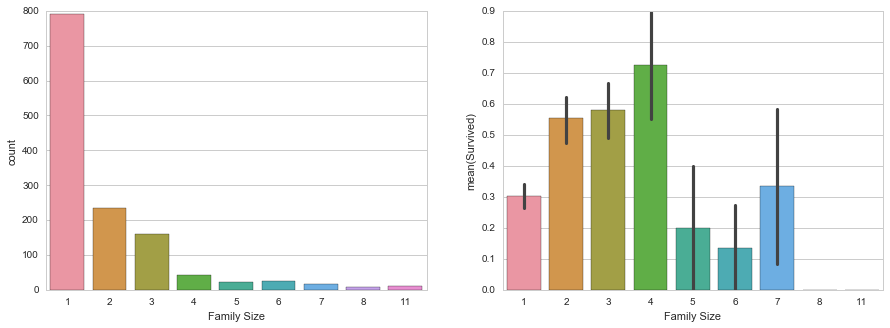

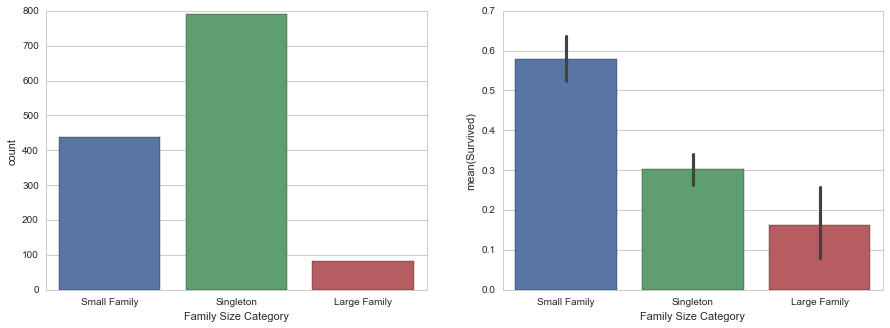

In [5]:
# 家庭人数
full_df['Family Size'] = full_df['SibSp'] + full_df['Parch'] + 1

# 展示家庭人数概要
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(x='Family Size', data=full_df, ax=ax[0])
sns.barplot(x='Family Size', y='Survived', data=full_df.loc['train'], ax=ax[1])

# 分为单人、2~4人、4人及以上（这么分 生存几率区分明显）
full_df.loc[full_df['Family Size'] == 1, 'Family Size Category'] = 'Singleton'
full_df.loc[full_df['Family Size'].isin([2,3,4]), 'Family Size Category'] = 'Small Family'
full_df.loc[full_df['Family Size'] >= 5, 'Family Size Category'] = 'Large Family'

# 展示家庭规模概要
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(x='Family Size Category', data=full_df, ax=ax[0])
sns.barplot(x='Family Size Category', y='Survived', data=full_df.loc['train'], ax=ax[1])

# 生成哑变量
full_df = full_df.join( pd.get_dummies(full_df['Family Size Category']).drop(['Large Family'], axis=1) )
full_df.drop(['SibSp', 'Parch', 'Family Size', 'Family Size Category'], axis=1, inplace=True)


### Embarked
* 由于就train_df有两个缺失值 就把缺失值填补为S(最多)

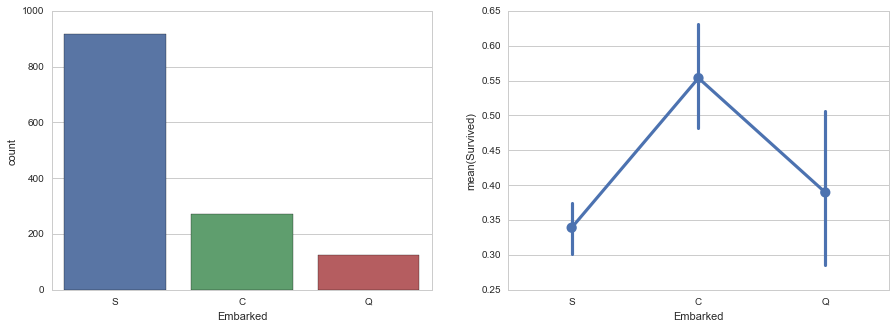

In [6]:
# 用众数填补缺失值
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
full_df['Embarked'].fillna( full_df['Embarked'].dropna().mode()[0], inplace=True )

# 分布
sns.countplot(x='Embarked', data=full_df, ax=ax1)
# 集中情况
sns.pointplot(x='Embarked', y='Survived', data=full_df.loc['train'], ax=ax2)

# 设置哑变量
full_df = full_df.join( pd.get_dummies(full_df['Embarked'], prefix='Embarked').drop(['Embarked_S'], axis=1) )
full_df.drop(['Embarked'], axis=1, inplace=True)


### Sex
* 分为Male, Female, Child（Age<16的为Child）

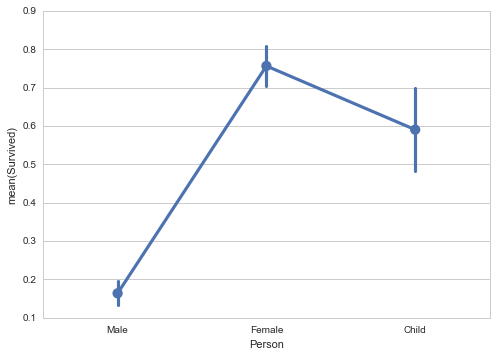

In [7]:
def get_person(passenger):
    age, sex = passenger
    return 'Child' if age < 16 else sex.capitalize()

# 获得人的类别
full_df['Person'] = full_df[['Age', 'Sex']].apply(get_person, axis=1)

# 查看数据
sns.pointplot(x='Person', y='Survived', data=full_df)

# 设置哑变量
full_df = full_df.join( pd.get_dummies(full_df['Person']).drop(['Male'], axis=1) )
full_df.drop(['Person', 'Sex'], axis=1, inplace=True)

### Age
* 缺失值填补(mean-std) between (mean+std)

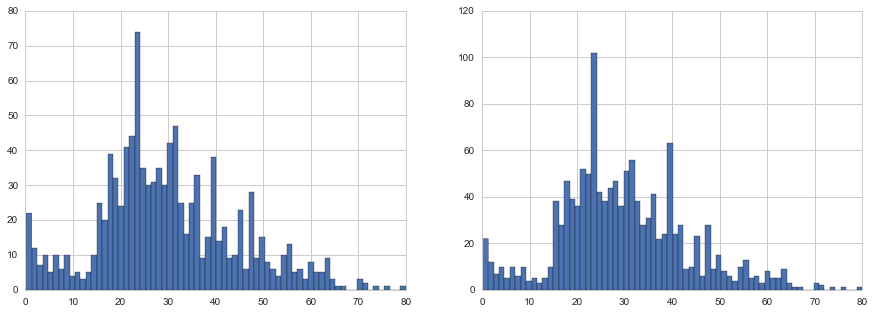

In [8]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax1.set_title('Age - original')
ax2.set_title('Age - new')

# 处理前
full_df['Age'].hist(bins=70, ax=ax[0])

# 获取均值 标准差 空值数量
age_mean = full_df['Age'].mean()
age_std = full_df['Age'].std()
age_nan_cnt = full_df['Age'].isnull().sum()

# 生成随机值
age_rand = np.random.randint(age_mean - age_std, age_mean + age_std, size=age_nan_cnt)

# 填补
full_df.loc[full_df['Age'].isnull(), 'Age'] = age_rand

# 处理后
full_df['Age'].hist(bins=70, ax=ax[1])

### Fare
* 由于缺失值很少，直接填充均值

dataset null value num: 1


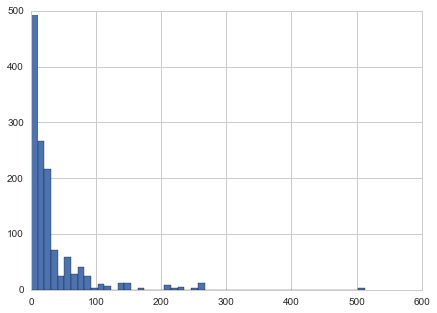

In [9]:
# 由于缺失值很少，直接填充均值
print('dataset null value num:', full_df['Fare'].isnull().sum()) # output: 1

# 填充均值
full_df['Fare'].fillna( full_df['Fare'].mean(), inplace=True )

fig, ax = plt.subplots(1,1,figsize=(7,5))
full_df['Fare'].hist(bins=50, ax=ax)

### Cabin

In [10]:
full_df['Deck'] = full_df.loc[~full_df['Cabin'].isnull(), 'Cabin'].apply(lambda x: x[0])

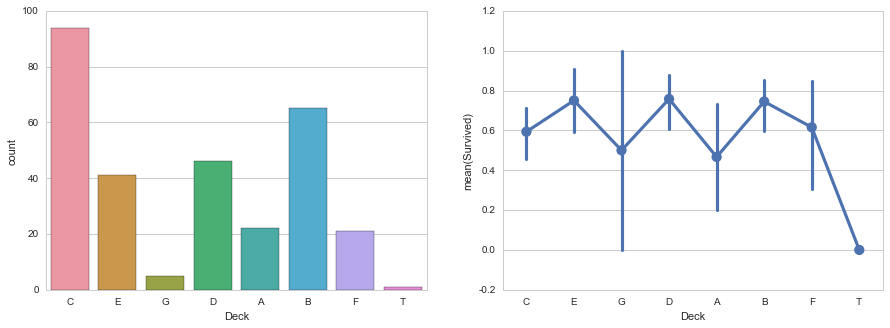

In [11]:
# 显示概况
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(x='Deck', data=full_df, ax=ax[0])
sns.pointplot(x='Deck', y='Survived', data=full_df.loc['train'], ax=ax[1])

# 生成哑变量
full_df = full_df.join( pd.get_dummies(full_df['Deck'], prefix='Deck').drop(['Deck_T'], axis=1) )
full_df.drop(['Deck', 'Cabin'], axis=1, inplace=True)

### 查看进行特征工程后数据的概况

In [12]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1309 entries, (train, 0) to (test, 417)
Data columns (total 23 columns):
Age             1309 non-null float64
Fare            1309 non-null float64
PassengerId     1309 non-null int64
Pclass          1309 non-null int64
Survived        891 non-null float64
Ticket          1309 non-null object
Master          1309 non-null uint8
Miss            1309 non-null uint8
Mr              1309 non-null uint8
Mrs             1309 non-null uint8
Singleton       1309 non-null uint8
Small Family    1309 non-null uint8
Embarked_C      1309 non-null uint8
Embarked_Q      1309 non-null uint8
Child           1309 non-null uint8
Female          1309 non-null uint8
Deck_A          1309 non-null uint8
Deck_B          1309 non-null uint8
Deck_C          1309 non-null uint8
Deck_D          1309 non-null uint8
Deck_E          1309 non-null uint8
Deck_F          1309 non-null uint8
Deck_G          1309 non-null uint8
dtypes: float64(3), int64(2), object(1), ui

In [13]:
full_df.head()

Age     Fare  PassengerId  Pclass  Survived            Ticket  \
train 0  22.0   7.2500            1       3       0.0         A/5 21171   
      1  38.0  71.2833            2       1       1.0          PC 17599   
      2  26.0   7.9250            3       3       1.0  STON/O2. 3101282   
      3  35.0  53.1000            4       1       1.0            113803   
      4  35.0   8.0500            5       3       0.0            373450   

         Master  Miss  Mr  Mrs   ...    Embarked_Q  Child  Female  Deck_A  \
train 0       0     0   1    0   ...             0      0       0       0   
      1       0     0   0    1   ...             0      0       1       0   
      2       0     1   0    0   ...             0      0       1       0   
      3       0     0   0    1   ...             0      0       1       0   
      4       0     0   1    0   ...             0      0       0       0   

         Deck_B  Deck_C  Deck_D  Deck_E  Deck_F  Deck_G  
train 0       0       0       0       0       0       0  
      1       0       1       0       0       0       0  
      2       0       0       0       0       0       0  
      3       0       1       0       0       0       0  
      4       0       0       0       0       0       0  

[5 rows x 23 columns]

### 预处理

In [14]:
# 删除没用的字段
full_df = full_df.drop(['Ticket'], axis=1)

# 训练数据
train_df = full_df.loc['train'].drop(['PassengerId'], axis=1)
X_train = train_df.drop(['Survived'], axis=1)
y_train = train_df['Survived']

# 需要预测的数据
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
X_pred = full_df.loc['test'].drop(['PassengerId', 'Survived'], axis=1)

In [15]:
score_name = 'Accuracy'
score_func = metrics.accuracy_score
scorer = metrics.make_scorer(score_func)

### Random Forest

In [16]:
# 对树的数量、最大深度进行调参
search_paras = {'n_estimators': [100,200,500,700], 'max_depth': [3,5,7,10,15]}
rf_cv = GridSearchCV(RandomForestClassifier(), search_paras, scoring=scorer)
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 500, 700], 'max_depth': [3, 5, 7, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(accuracy_score), verbose=0)

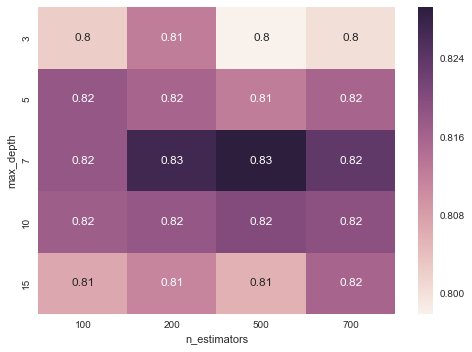

In [17]:
plot_grid_search_result(rf_cv)

In [18]:
# 训练
print('Best Params:', rf_cv.best_params_)
rf = RandomForestClassifier(**rf_cv.best_params_)
rf.fit(X_train, y_train)
print('RandomForestClassifier Accuracy:', score_func(y_train, rf.predict(X_train)))

Best Params: {'n_estimators': 500, 'max_depth': 7}
RandomForestClassifier Accuracy: 0.888888888889


In [19]:
# 特征重要性查看
feature_importances_df = pd.DataFrame(data=[rf.feature_importances_], columns=X_train.columns)
feature_importances_df.sort_values(by=0, axis=1, ascending=False)

,Mr,Female,Fare,Pclass,Age,Miss,Mrs,Small Family,Singleton,Embarked_C,Child,Deck_E,Embarked_Q,Deck_D,Master,Deck_B,Deck_C,Deck_A,Deck_F,Deck_G
0,0.216215,0.156494,0.1421,0.099601,0.097759,0.059624,0.054475,0.045147,0.02091,0.018292,0.017259,0.015893,0.011782,0.010019,0.009893,0.009846,0.007929,0.002587,0.002339,0.001835


### Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

In [22]:
search_paras = {'penalty': ['l1', 'l2'], 'C': np.logspace(-4, 4, 9)}
lr_cv = GridSearchCV(LogisticRegression(), search_paras, scoring=scorer)
lr_cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01,   1.00000e+02,   1.00000e+03,
         1.00000e+04]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(accuracy_score), verbose=0)

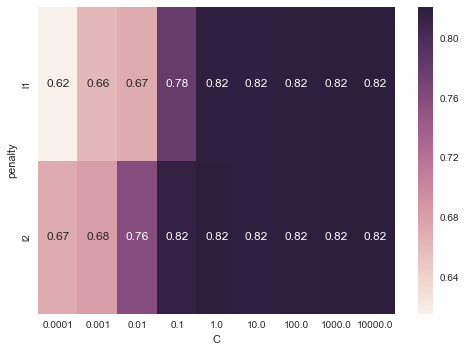

In [24]:
plot_grid_search_result(lr_cv)

In [26]:
# 训练
print('Best Params:', lr_cv.best_params_)
lr = LogisticRegression(**lr_cv.best_params_)
lr.fit(X_train, y_train)
print('RandomForestClassifier Accuracy:', score_func(y_train, lr.predict(X_train)))

Best Params: {'C': 1.0, 'penalty': 'l2'}
RandomForestClassifier Accuracy: 0.835016835017


### 将预测结果导出

In [24]:
# 使用的模型
res_model = rf

# 预测
y_pred = res_model.predict(X_pred.values)

result = pd.DataFrame({
        'PassengerId': test_df['PassengerId'],
        'Survived': y_pred.astype(int),
    }
)
result.to_csv('./data/result.csv', index=False)